In [1]:
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import xarray as xr
import zarr as zr

## (De-)Serialisation of Simulations

We import a batch of perturbation simulations, which were emitted by `Vivarium` into a `Zarr` store, as an `xarray.DataTree` object.

In [2]:
store_path = "./E_coli_Millard2016.zip"
store = zr.storage.ZipStore(store_path, read_only=True)
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message=".*Zarr format 3", category=UserWarning)
    trace = xr.open_datatree(store, engine="zarr")
store.close()
print(trace)

<xarray.DataTree>
Group: /
│   Dimensions:  (species: 77)
│   Coordinates:
│     * species  (species) object 616B 'ACCOA' 'ACO' 'ACP' ... 'GLCp' 'Pp' 'ACEp'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/E_coli_Mil...
└── Group: /perturbations
    │   Dimensions:        (condition: 4, perturb_param: 1, perturb_ic: 2)
    │   Coordinates:
    │     * perturb_param  (perturb_param) object 8B 'FEED'
    │     * condition      (condition) object 32B 'Default' ... 'No glucose & no phos...
    │     * perturb_ic     (perturb_ic) object 16B 'Px' 'GLCx'
    │   Data variables:
    │       param          (condition, perturb_param) float64 32B ...
    │       ic             (condition, perturb_ic) float64 64B ...
    │   Attributes:
    │       time_step:  1.0
    └── Group: /perturbations/timeseries
            Dimensions:        (condition: 4, time: 301, species: 77)
            Coordinates:
                time           (condition, time) float64 10kB .

The `DataTree` metadata provides insight into the high-level structure of the perturbation study:

In [3]:
len(trace.species)

77

In [4]:
P = trace.perturbations
P.coords

Coordinates:
  * species        (species) object 616B 'ACCOA' 'ACO' 'ACP' ... 'Pp' 'ACEp'
  * perturb_param  (perturb_param) object 8B 'FEED'
  * condition      (condition) object 32B 'Default' ... 'No glucose & no phos...
  * perturb_ic     (perturb_ic) object 16B 'Px' 'GLCx'

The perturbed conditions are labelled, and correspond to changes in:
- initial conditions of endogenous variables (here: internal/external metabolite concentrations),
- values of exogenous parameters (here: externally controlled metabolite fluxes).

In [5]:
P.ic.to_dataframe()

ic
condition                 perturb_ic     
Default                   Px          1.0
                          GLCx        1.0
No glucose                Px          1.0
                          GLCx        0.0
No phosphate              Px          0.0
                          GLCx        1.0
No glucose & no phosphate Px          0.0
                          GLCx        0.0

In [6]:
P.param.to_dataframe()

,,param
condition,perturb_param,
Default,FEED,1.0
No glucose,FEED,0.0
No phosphate,FEED,1.0
No glucose & no phosphate,FEED,0.0


The full `DataTree` format can also be navigated interactively in an HTML display.

In [7]:
trace

<xarray.DataTree>
Group: /
│   Dimensions:  (species: 77)
│   Coordinates:
│     * species  (species) object 616B 'ACCOA' 'ACO' 'ACP' ... 'GLCp' 'Pp' 'ACEp'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/E_coli_Mil...
└── Group: /perturbations
    │   Dimensions:        (condition: 4, perturb_param: 1, perturb_ic: 2)
    │   Coordinates:
    │     * perturb_param  (perturb_param) object 8B 'FEED'
    │     * condition      (condition) object 32B 'Default' ... 'No glucose & no phos...
    │     * perturb_ic     (perturb_ic) object 16B 'Px' 'GLCx'
    │   Data variables:
    │       param          (condition, perturb_param) float64 32B ...
    │       ic             (condition, perturb_ic) float64 64B ...
    │   Attributes:
    │       time_step:  1.0
    └── Group: /perturbations/timeseries
            Dimensions:        (condition: 4, time: 301, species: 77)
            Coordinates:
                time           (condition, time) float64 10kB ...
            Data variables:
                count          (condition, time, species) float64 742kB ...

## Visualisation

Finally, we plot the concentrations of some key molecules, in order to assess the response of self-regulating metabolic control to environment perturbations.

In [8]:
def plot_sensitivity(
    trace: xr.DataTree,
    plot_species=["GLX", "FUM", "PYR", "ACCOA", "AKG", "SUCCOA", "OAA"]
):
    assert isinstance(trace, xr.DataTree)
    sim = trace["/perturbations"]
    plt.rcParams["figure.dpi"] = 120
    fig = plt.figure(constrained_layout=True, figsize=(16, 5))
    plt.suptitle("Sensitivity to perturbations of metabolite availability", fontsize="x-large")
    axs = fig.subplots(nrows=1, ncols=len(sim.condition))
    for (j, (c, ax)) in enumerate(zip(sim.condition, axs)):
        traj = sim["timeseries"].sel(condition=c)
        for sp in plot_species:
            ax.plot(traj["time"].to_numpy(), traj["count"].sel(species=sp).to_numpy(),
                    ls='-', marker='o', markevery=20, label=sp)
        ax.grid(alpha=.3)
        ax.set_title(f"Perturbation: {c.item()}", fontsize="large")
        ax.legend(loc="upper right", fontsize="small")
        ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Metabolites (mol)")
    plt.show()

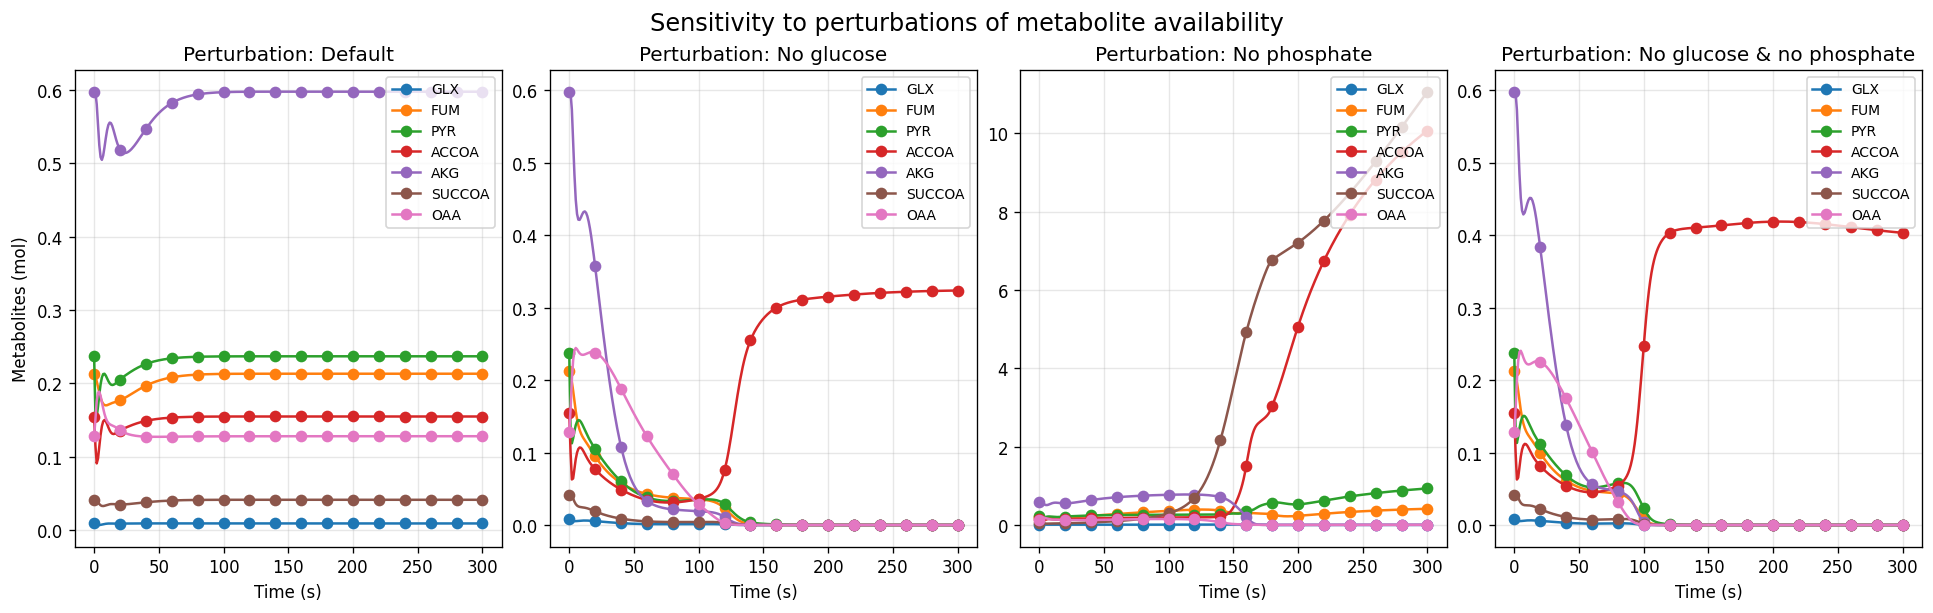

In [9]:
plot_sensitivity(trace)